In [1]:
import stable_baselines
from stable_baselines import DQN, A2C, ACER, ACKTR, PPO2
from stable_baselines.common.policies import MlpPolicy

from gameRL.game_simulators.blackjack import (
    BlackjackDeck,
    BlackjackCustomEnv,
    BlackjackDeckwithCount,
    BlackjackEnvwithRunningCount,
    BlackjackEnvwithTrueCount,
)
import seaborn as sns
import warnings
import numpy as np
warnings.filterwarnings('ignore')

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [52]:
def get_model(model_path):
    model = None
    if "a2c" in model_path:
        model = A2C.load(model_path)
    elif "acer" in model_path:
        model = ACER.load(model_path)
    elif "acktr" in model_path:
        model = ACKTR.load(model_path)
    elif "ppo2" in model_path:
        model = PPO2.load(model_path)
    elif "dqn" in model_path:
        model = DQN.load(model_path)
    return model


def get_correct_env(var, num_decks, rho=1):
    if var == "basic":
        return BlackjackCustomEnv(num_decks)
    else:
        return BlackjackEnvwithRunningCount(num_decks, rho=rho)


def set_cur_state(
    env, dealer_hand, dummy_hand, player_hand=None, observing=False, count=None
):
    if not observing:
        env.step(2)
    env.dealer.hand = dealer_hand
    env.dummy.hand = dummy_hand
    if player_hand is not None:
        env.player.hand = player_hand
    env.observing = observing
    if count is not None:
        env.blackjack_deck.count = count
    return env

def set_basic_state(env, dealer_hand, player_hand):
    env.reset()
    env.dealer.hand = dealer_hand
    env.player.hand = player_hand
    return env
    

def get_policy_profile(model, obs, iters=1000):
    action_count = {0: 0, 1: 0, 2: 0, 3: 0, 4:0}
    for _ in range(iters):
        action, _states = model.predict(obs, deterministic=False)
        action_count[action] += 1
    print(action_count)
    return np.array(list(action_count.values())) / iters

def clean_up_strategy_profile(probs, observing):
    # 0: Stick, 1: Hit, 2: Join, 3: Observe, 4: Double Down
    if observing:
        probs[3] = np.sum(probs) - probs[2]
        probs[0] = 0
        probs[1] = 0
        probs[4] = 0
    else:
        probs[0] = probs[0] + probs[2]
        probs[2] = 0
    return probs



In [115]:
path = "/Users/max/Desktop/6.867/Final Project/gameRL/saved_models/saved_models/dqn_sum_21_rho_0.75_nd_10.zip"
env = get_correct_env("adv", 1, rho=0.75)
env.reset()
model = get_model(path)
print(model.sess)
env = set_cur_state(env, [3, 3], [2, 2], [6,4], False, count=15)
# env = set_basic_state(env, [3,3], [10,1])
obs = env._get_obs()
print("obs", obs)
counts = list(range(-5, 6))
profs = []
observing = False
for count in counts:
# count = 0
# for i in range(1, 11):
    env = set_cur_state(env, [10, i], [5, 3], [2, 2], observing, count=count)
    obs = env._get_obs()
    print(obs)
    prof = model.action_probability(obs)
    clean = clean_up_strategy_profile(prof, observing)
    profs.append(prof)
arr = np.array(profs)
print(arr)

obs (10, 3, False, 15, False)
(4, 10, False, -5, False)
(4, 10, False, -4, False)
(4, 10, False, -3, False)
(4, 10, False, -2, False)
(0, 1, False, -1, False)
(0, 1, False, 0, False)
(0, 1, False, 1, False)
(0, 1, False, 2, False)
(0, 1, False, 3, False)
(0, 1, False, 4, False)
(0, 1, False, 5, False)
[[0.45888197 0.24075224 0.         0.2642195  0.03614631]
 [0.45888197 0.24075224 0.         0.2642195  0.03614631]
 [0.45888197 0.24075224 0.         0.2642195  0.03614631]
 [0.45888197 0.24075224 0.         0.2642195  0.03614631]
 [0.48294306 0.21032995 0.         0.237076   0.06965098]
 [0.43162197 0.23489568 0.         0.26387122 0.06961112]
 [0.3469262  0.22250693 0.         0.18800287 0.24256401]
 [0.5052303  0.19121855 0.         0.24143405 0.06211714]
 [0.45519394 0.2129262  0.         0.22861299 0.10326687]
 [0.46458143 0.22007291 0.         0.23696911 0.07837652]
 [0.42388168 0.23199515 0.         0.258289   0.0858342 ]]


<AxesSubplot:>

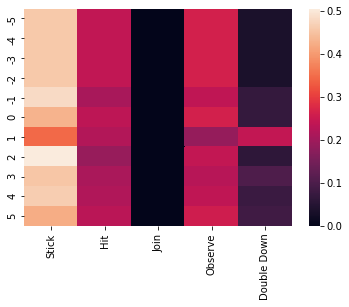

In [116]:
x_labels = ["Stick", "Hit", "Join", "Observe", "Double Down"]
sns.heatmap(arr, xticklabels=x_labels, yticklabels=counts)